Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# GAN Workflow Engine with the MedNIST Dataset

The MONAI framework can be used to easily design, train, and evaluate generative adversarial networks.
This notebook exemplifies using MONAI components to design and train a simple GAN model to reconstruct images of Hand CT scans.

Read the [MONAI Mednist GAN Tutorial](./mednist_GAN_tutorial.ipynb) for details about the network architecture and loss functions.

**Table of Contents**

1. Setup
2. Initialize MONAI Components
    * Create image transform chain
    * Create dataset and dataloader
    * Define generator and discriminator
    * Create training handlers
    * Create GanTrainer
3. Run Training
4. Evaluate Results

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/mednist_GAN_workflow_dict.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 13.2 MB/s eta 0:00:00


## Setup imports

In [2]:
from monai.utils import set_determinism
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.networks.nets import Discriminator, Generator
from monai.networks import normal_init
from monai.handlers import CheckpointSaver, MetricLogger, StatsHandler
from monai.engines.utils import GanKeys, default_make_latent
from monai.engines import GanTrainer
from monai.data import CacheDataset, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
import matplotlib.pyplot as plt
import tempfile
import sys
import shutil
import os
import logging

print_config()

MONAI version: 1.4.dev2401
Numpy version: 1.23.5
Pytorch version: 2.1.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 54374e01eaa7a279d52b299e73016ba875045eb6
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.6.6
TorchVision version: 0.16.2+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpl43_93g_


## Download dataset

Downloads and extracts the dataset.

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](https://www.rsna.org/education/ai-resources-and-training/ai-image-challenge/rsna-pediatric-bone-age-challenge-2017),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).


If you use the MedNIST dataset, please acknowledge the source.

In [4]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:00, 68.7MB/s]                            

2024-01-09 16:37:03,255 - INFO - Downloaded: /tmp/tmpl43_93g_/MedNIST.tar.gz


2024-01-09 16:37:03,407 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-01-09 16:37:03,414 - INFO - Writing into directory: /tmp/tmpl43_93g_.


In [5]:
hand_dir = os.path.join(data_dir, "Hand")
training_datadict = [{"hand": os.path.join(hand_dir, filename)} for filename in os.listdir(hand_dir)]

In [6]:
print(training_datadict[:5])

[{'hand': '/tmp/tmpl43_93g_/MedNIST/Hand/009961.jpeg'}, {'hand': '/tmp/tmpl43_93g_/MedNIST/Hand/008086.jpeg'}, {'hand': '/tmp/tmpl43_93g_/MedNIST/Hand/002972.jpeg'}, {'hand': '/tmp/tmpl43_93g_/MedNIST/Hand/003851.jpeg'}, {'hand': '/tmp/tmpl43_93g_/MedNIST/Hand/002359.jpeg'}]


## Initialize MONAI components

In [7]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda:0")

### Create image transform chain

Define the processing pipeline to convert saved disk images into usable Tensors.

In [8]:
train_transforms = Compose(
    [
        LoadImageD(keys=["hand"]),
        EnsureChannelFirstD(keys=["hand"], channel_dim="no_channel"),
        ScaleIntensityD(keys=["hand"]),
        RandRotateD(keys=["hand"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["hand"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["hand"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["hand"]),
    ]
)

### Create dataset and dataloader

Hold data and present batches during training.

In [9]:
real_dataset = CacheDataset(training_datadict, train_transforms)

Loading dataset: 100%|██████████| 10000/10000 [00:12<00:00, 806.88it/s]


In [10]:
batch_size = 300
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=10)


def prepare_batch(batchdata, device=None, non_blocking=False):
    return batchdata["hand"].to(device=device, non_blocking=non_blocking)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
!apt-get --purge remove cuda
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'cuda' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Found existing installation: torch 2.1.2
Uninstalling torch-2.1.2:
  Successfully uninstalled torch-2.1.2
Found existing installation: torchvision 0.16.2
Uninstalling torchvision-0.16.2:
  Successfully uninstalled torchvision-0.16.2
Found existing installation: torchaudio 2.1.2
Uninstalling torchaudio-2.1.2:
  Successfully uninstalled torchaudio-2.1.2
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser imp

### Define generator and discriminator

Load basic computer vision GAN networks from libraries.

In [12]:
# define networks
disc_net = Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=5,
).to(device)

latent_size = 64
gen_net = Generator(
    latent_shape=latent_size,
    start_shape=(latent_size, 8, 8),
    channels=[32, 16, 8, 1],
    strides=[2, 2, 2, 1],
)
gen_net.conv.add_module("activation", torch.nn.Sigmoid())
gen_net = gen_net.to(device)

# initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

# define optimizors
learning_rate = 2e-4
betas = (0.5, 0.999)
disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)

# define loss functions
disc_loss_criterion = torch.nn.BCELoss()
gen_loss_criterion = torch.nn.BCELoss()
real_label = 1
fake_label = 0


def discriminator_loss(gen_images, real_images):
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), fake_label)

    realloss = disc_loss_criterion(disc_net(real_images), real)
    genloss = disc_loss_criterion(disc_net(gen_images.detach()), gen)

    return (genloss + realloss) / 2


def generator_loss(gen_images):
    output = disc_net(gen_images)
    cats = output.new_full(output.shape, real_label)
    return gen_loss_criterion(output, cats)

In [13]:
metric_logger = MetricLogger(
    loss_transform=lambda x: {GanKeys.GLOSS: x[GanKeys.GLOSS], GanKeys.DLOSS: x[GanKeys.DLOSS]},
    metric_transform=lambda x: x,
)

handlers = [
    StatsHandler(
        name="batch_training_loss",
        output_transform=lambda x: {
            GanKeys.GLOSS: x[GanKeys.GLOSS],
            GanKeys.DLOSS: x[GanKeys.DLOSS],
        },
    ),
    CheckpointSaver(
        save_dir=os.path.join(root_dir, "hand-gan"),
        save_dict={"g_net": gen_net, "d_net": disc_net},
        save_interval=10,
        save_final=True,
        epoch_level=True,
    ),
    metric_logger,
]

### Create GanTrainer

MONAI Workflow engine for adversarial learning. The components come together here with the GanTrainer.
```
Training Loop: for each batch of data size m
        1. Generate m fakes from random latent codes.
        2. Update D with these fakes and current batch reals, repeated d_train_steps times.
        3. Generate m fakes from new random latent codes.
        4. Update generator with these fakes using discriminator feedback.
```

In [14]:
disc_train_steps = 5
max_epochs = 50

trainer = GanTrainer(
    device,
    max_epochs,
    real_dataloader,
    gen_net,
    gen_opt,
    generator_loss,
    disc_net,
    disc_opt,
    discriminator_loss,
    d_prepare_batch=prepare_batch,
    d_train_steps=disc_train_steps,
    g_update_latents=True,
    latent_shape=latent_size,
    key_train_metric=None,
    train_handlers=handlers,
)

## Start Training

In [15]:
trainer.run()

2024-01-09 16:38:46,761 - INFO - Epoch: 1/50, Iter: 1/34 -- d_loss: 3.2239 g_loss: 0.8404 
2024-01-09 16:38:49,280 - INFO - Epoch: 1/50, Iter: 2/34 -- d_loss: 2.4710 g_loss: 1.1411 
2024-01-09 16:38:51,461 - INFO - Epoch: 1/50, Iter: 3/34 -- d_loss: 1.5043 g_loss: 1.6696 
2024-01-09 16:38:52,605 - INFO - Epoch: 1/50, Iter: 4/34 -- d_loss: 0.7158 g_loss: 2.4028 
2024-01-09 16:38:53,591 - INFO - Epoch: 1/50, Iter: 5/34 -- d_loss: 0.3420 g_loss: 3.1120 
2024-01-09 16:38:54,446 - INFO - Epoch: 1/50, Iter: 6/34 -- d_loss: 0.1602 g_loss: 3.7967 
2024-01-09 16:38:55,300 - INFO - Epoch: 1/50, Iter: 7/34 -- d_loss: 0.1230 g_loss: 4.2621 
2024-01-09 16:38:56,286 - INFO - Epoch: 1/50, Iter: 8/34 -- d_loss: 0.1172 g_loss: 4.4082 
2024-01-09 16:38:57,553 - INFO - Epoch: 1/50, Iter: 9/34 -- d_loss: 0.0764 g_loss: 4.6501 
2024-01-09 16:38:58,877 - INFO - Epoch: 1/50, Iter: 10/34 -- d_loss: 0.0892 g_loss: 4.7795 
2024-01-09 16:39:09,128 - INFO - Epoch: 1/50, Iter: 11/34 -- d_loss: 0.1301 g_loss: 4.839

## Evaluate Results

Examine G and D loss curves for collapse.

In [16]:
g_loss = [loss[1][GanKeys.GLOSS] for loss in metric_logger.loss]
d_loss = [loss[1][GanKeys.DLOSS] for loss in metric_logger.loss]

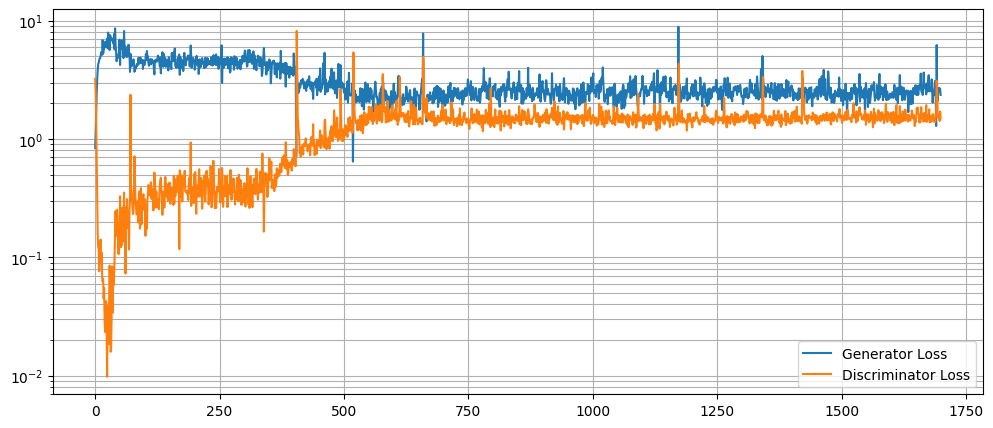

In [17]:
plt.figure(figsize=(12, 5))
plt.semilogy(g_loss, label="Generator Loss")
plt.semilogy(d_loss, label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.show()

### View image reconstructions
With random latent codes view trained generator output.

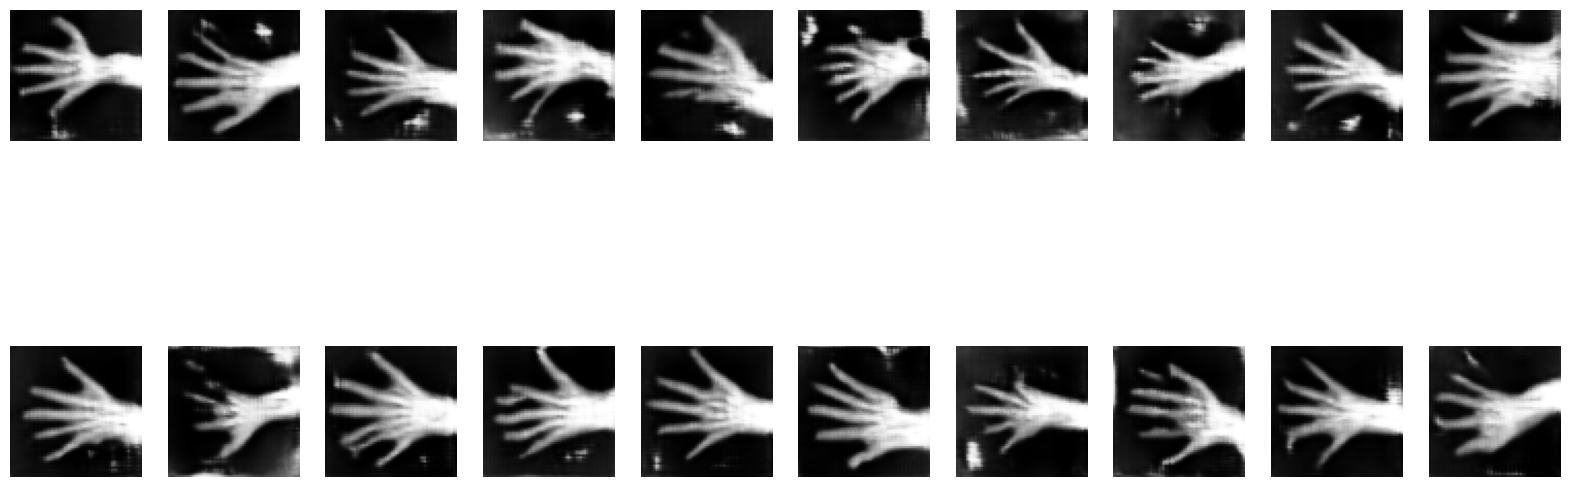

In [20]:
test_img_count = 20
test_latents = default_make_latent(test_img_count, latent_size).to(device)
fakes = gen_net(test_latents)

fig, axs = plt.subplots(2, (test_img_count // 2), figsize=(20, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(fakes[i, 0].cpu().data.numpy(), cmap="gray")

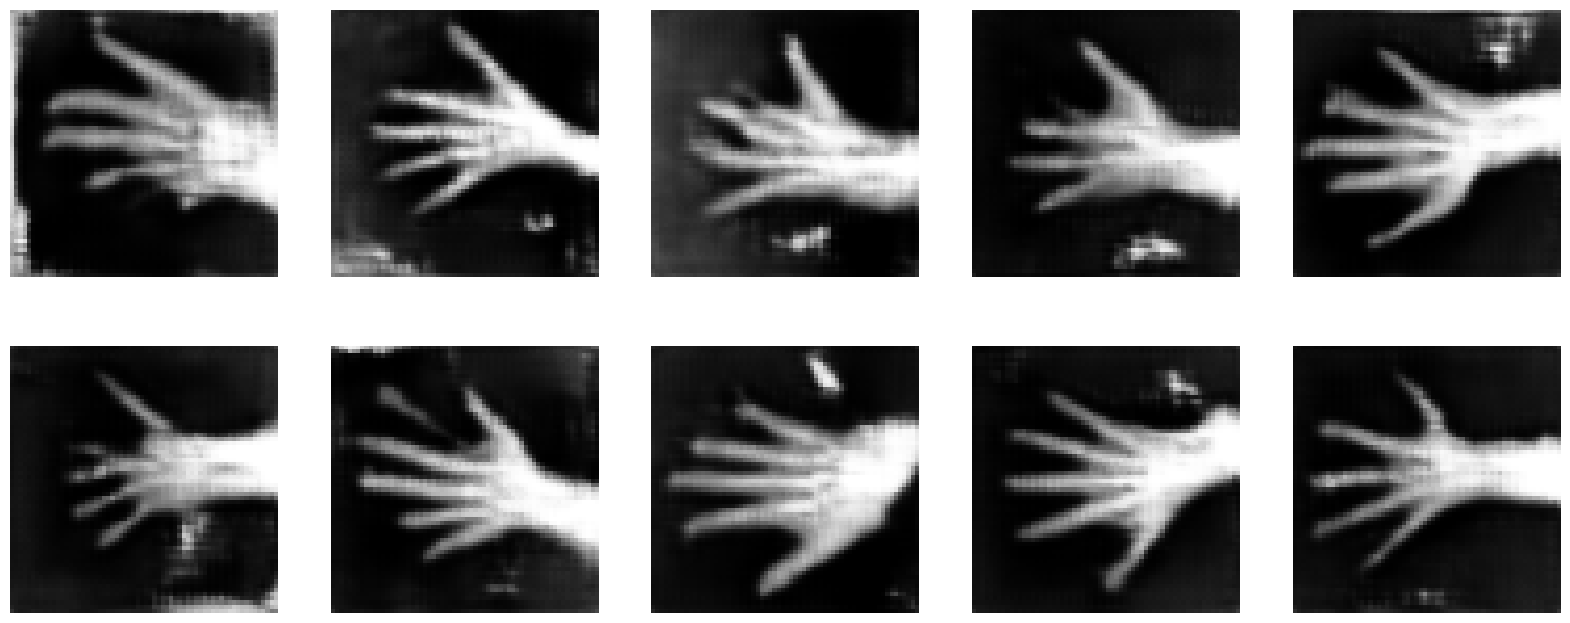

In [19]:
import matplotlib.pyplot as plt
import os

# Your existing code...

# Save the generated images
output_directory = 'output_images'  # Change this to the desired directory
os.makedirs(output_directory, exist_ok=True)

for i in range(test_img_count):
    image_path = os.path.join(output_directory, f'generated_image_{i + 1}.jpg')
    plt.imsave(image_path, fakes[i, 0].cpu().data.numpy(), cmap="gray")

# Display the generated images
fig, axs = plt.subplots(2, (test_img_count // 2), figsize=(20, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(fakes[i, 0].cpu().data.numpy(), cmap="gray")

plt.show()


### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)